# The Influence of Geographical, Economic, Social, and Unemployment Factors on Real Estate Prices in Bangkok

### COLLECTION & SETUP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.unicode_minus'] = False

### DATA CLEANING

In [5]:
try:
    df_property = pd.read_csv('df_cleaned.csv')
    df_train = pd.read_csv('Train.csv')
    df_interest_raw = pd.read_csv('FM_RT_2018_2019.csv', skiprows=5, header=0)
    # df_people_raw = pd.read_csv('people2019.csv', skiprows=3, header=0, encoding='utf-8') # ไม่ใช้ใน V4
    df_work_raw = pd.read_csv('work2.csv', encoding='utf-8-sig')
    
    print("File loaded successfully.")
except Exception as e:
    print(f"Failed to load file. {e}")
    raise

File loaded successfully.


In [6]:
df_property['date'] = pd.to_datetime(df_property['date'])
df_property['year_month_str'] = df_property['date'].dt.to_period('M').astype(str) # Key 1
df_property['year'] = df_property['date'].dt.year
df_property['quarter'] = df_property['date'].dt.quarter                 # Key 2
df_property['year_buddhist'] = df_property['year'] + 543    

**ฟังก์ชันคำนวณระยะทางจาก GPS**
## Feature Engineering

In [7]:
def haversine_vectorized(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # รัศมีโลก (กม.)
    return c * r

**"สร้าง Feature ใหม่" ที่ชื่อว่า dist_nearest_station (ระยะทางไปยังสถานีรถไฟฟ้าที่ใกล้ที่สุด)**

In [8]:
df_train = df_train.dropna(subset=['geoLat', 'geoLng'])
train_locations = df_train[['geoLng', 'geoLat']].values
def find_nearest_station_dist(row):
    distances = haversine_vectorized(row['longitude'], row['latitude'], train_locations[:, 0], train_locations[:, 1])
    return np.min(distances)
print("กำลังคำนวณปัจจัยภูมิศาสตร์")
df_property['dist_nearest_station'] = df_property.apply(find_nearest_station_dist, axis=1)

กำลังคำนวณปัจจัยภูมิศาสตร์


**การแปลงตาราง Wide Format เป็น Long Format**

In [9]:
print("เตรียมปัจจัยเศรษฐกิจ 1 (ดอกเบี้ย)")
df_interest = df_interest_raw[df_interest_raw['Unnamed: 1'].str.contains('อัตราดอกเบี้ยนโยบาย', na=False)] #"อัตราดอกเบี้ยนโยบาย"
df_interest_melted = df_interest.melt(id_vars=['Unnamed: 1'], value_vars=df_interest.columns[2:], 
                                    var_name='date_str_raw', value_name='policy_rate')
thai_month_map = {
    'ม.ค.': '01', 'ก.พ.': '02', 'มี.ค.': '03', 'เม.ย.': '04', 'พ.ค.': '05', 'มิ.ย.': '06',
    'ก.ค.': '07', 'ส.ค.': '08', 'ก.ย.': '09', 'ต.ค.': '10', 'พ.ย.': '11', 'ธ.ค.': '12'
}
def clean_interest_date(date_str):
    date_str = str(date_str).strip().replace(' p', '')
    parts = date_str.split(' ')
    if len(parts) == 2:
        month_thai, year_buddhist = parts
        month_eng = thai_month_map.get(month_thai)
        if month_eng:
            try:
                year_christ = int(year_buddhist) - 543
                return f"{year_christ}-{month_eng}"
            except ValueError: return None
    return None
df_interest_melted['year_month_str'] = df_interest_melted['date_str_raw'].apply(clean_interest_date)
df_interest_melted['policy_rate'] = pd.to_numeric(df_interest_melted['policy_rate'], errors='coerce')
df_interest_final = df_interest_melted[['year_month_str', 'policy_rate']].drop_duplicates().dropna()

เตรียมปัจจัยเศรษฐกิจ 1 (ดอกเบี้ย)


In [10]:
print("เตรียมปัจจัยเศรษฐกิจ 2 (ผู้ว่างงาน)")
df_work_raw['region'] = df_work_raw['region'].str.replace(r'\d+\) ', '', regex=True).str.strip()
df_work_bkk = df_work_raw[
    (df_work_raw['region'] == 'กรุงเทพมหานคร') &
    (df_work_raw['unit'] == 'พันคน')
].copy()
quarter_map = {
    'ไตรมาส 1': 1, 'ไตรมาส 2': 2, 'ไตรมาส 3': 3, 'ไตรมาส 4': 4,
    'ไตรมาสที่ 1': 1, 'ไตรมาสที่ 2': 2, 'ไตรมาสที่ 3': 3, 'ไตรมาสที่ 4': 4
}
df_work_bkk['quarter_cleaned'] = df_work_bkk['quarter'].str.split('/').str[0].str.strip()
df_work_bkk['quarter_num'] = df_work_bkk['quarter_cleaned'].map(quarter_map)
df_work_bkk['year_buddhist'] = df_work_bkk['year']
df_work_bkk = df_work_bkk.rename(columns={'value': 'unemployment_count_k'}) 
df_work_final = df_work_bkk[['year_buddhist', 'quarter_num', 'unemployment_count_k']].drop_duplicates()


เตรียมปัจจัยเศรษฐกิจ 2 (ผู้ว่างงาน)


In [11]:
print("กำลังรวมข้อมูล V4 (Property + Geo + Economic 1 + Economic 2)...")
master_df = pd.merge(df_property, df_interest_final, on='year_month_str', how='left')
master_df = pd.merge(master_df, df_work_final, 
                     left_on=['year_buddhist', 'quarter'], 
                     right_on=['year_buddhist', 'quarter_num'], 
                     how='left')

กำลังรวมข้อมูล V4 (Property + Geo + Economic 1 + Economic 2)...


In [12]:
final_columns_to_check = ['policy_rate', 'unemployment_count_k', 'dist_nearest_station', 'value']
master_df_final = master_df.dropna(subset=final_columns_to_check)

print(f"สร้าง Master Table V4 สำเร็จ! (พบ {len(master_df_final)} แถว)")
print(f"  - (วิเคราะห์ข้อมูลในช่วง {master_df_final['date'].min().date()} ถึง {master_df_final['date'].max().date()})")
print("  - หมายเหตุ: ได้ข้อมูลตลอดปี 2018-2019 กลับมาแล้ว")

สร้าง Master Table V4 สำเร็จ! (พบ 5092 แถว)
  - (วิเคราะห์ข้อมูลในช่วง 2018-01-01 ถึง 2019-01-01)
  - หมายเหตุ: ได้ข้อมูลตลอดปี 2018-2019 กลับมาแล้ว


### EXPLORATORY DATA ANALYSIS

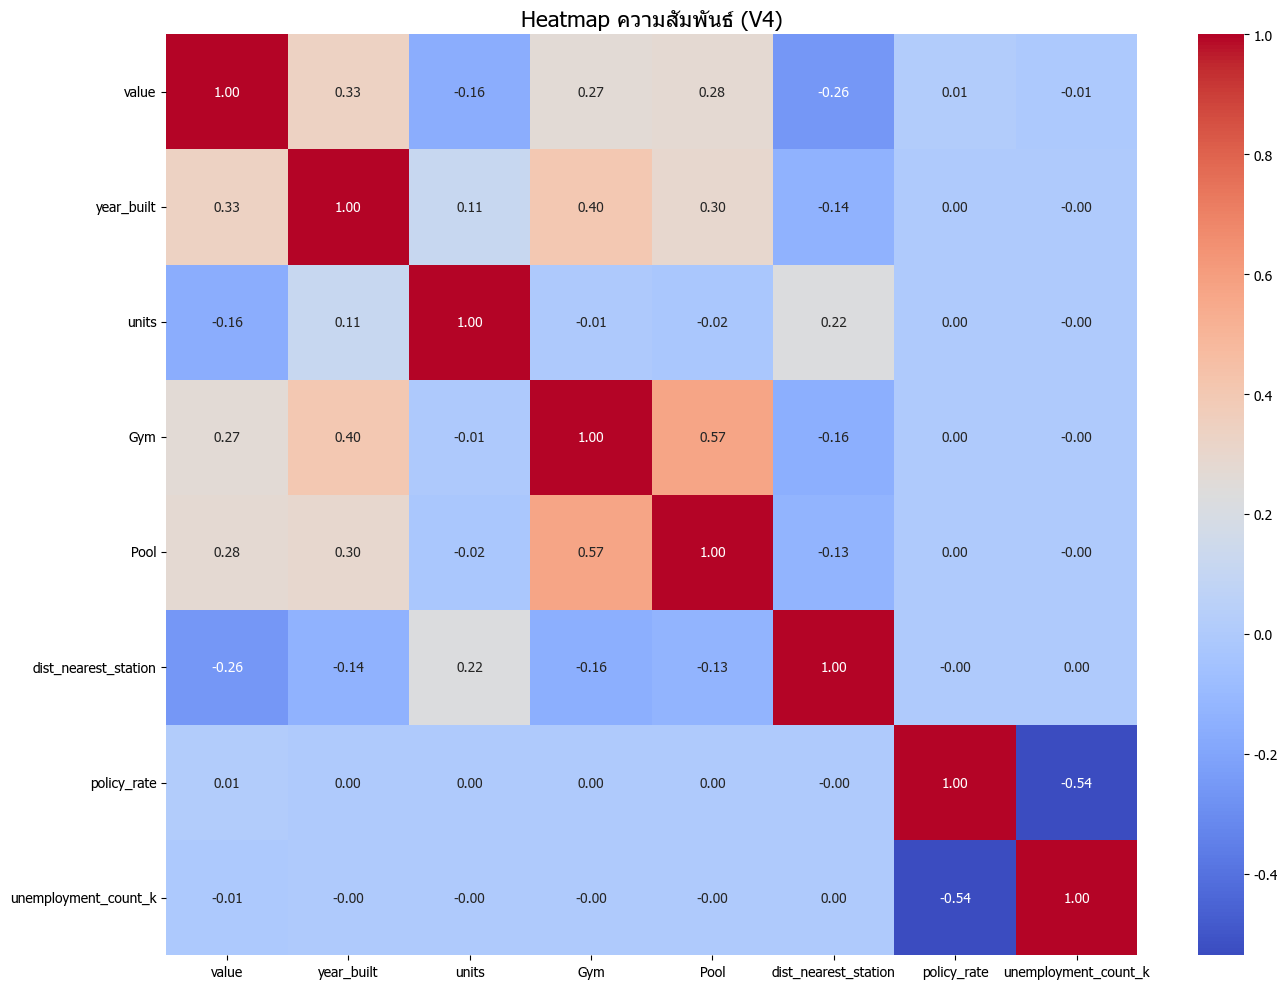

In [13]:
plt.figure(figsize=(14, 10))
features_to_explore = [
    'value', # y
    'year_built', 'units', 'Gym', 'Pool',
    'dist_nearest_station', 
    'policy_rate',         
    'unemployment_count_k' 
]
corr_matrix = master_df_final[features_to_explore].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap ความสัมพันธ์ (V4)', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap_v4.png')
plt.show()

### Data Pre-Processing

In [14]:
target = 'value'

numeric_features = [
    'latitude', 'longitude', 'year_built', 'proj_area', 'nbr_floors', 'units',

    'Elevator', 'Parking', 'Security', 'CCTV', 'Pool', 'Sauna', 'Gym', 'Garden', 
    'Playground', 'Shop', 'Restaurant', 'Wifi',
    'dist_nearest_station',
    'policy_rate',
    'unemployment_count_k'
]
categorical_features = ['district']

X = master_df_final[numeric_features + categorical_features]
y = master_df_final[target]

print(f"  - ตัวแปรตาม (y): {target}")
print(f"  - จำนวนตัวแปรต้น (X): {len(numeric_features)} (ตัวเลข) + {len(categorical_features)} (หมวดหมู่)")

  - ตัวแปรตาม (y): value
  - จำนวนตัวแปรต้น (X): 21 (ตัวเลข) + 1 (หมวดหมู่)


In [15]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"  - ขนาดข้อมูล Train: {X_train.shape[0]} แถว")
print(f"  - ขนาดข้อมูล Test: {X_test.shape[0]} แถว")

  - ขนาดข้อมูล Train: 4073 แถว
  - ขนาดข้อมูล Test: 1019 แถว


### Modeling

**สร้าง Model 1: Random Forest Regressor (RF)**

In [17]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=5
    ))
])

สร้าง Model 2: Gradient Boosting Regressor (GB)

In [18]:
model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=5
    ))
])

In [19]:
print("  - กำลังฝึกสอน Model 1: Random Forest...")
model_rf.fit(X_train, y_train)
print("  - กำลังฝึกสอน Model 2: Gradient Boosting...")
model_gb.fit(X_train, y_train)
print("ฝึกสอนโมเดลทั้ง 2 สำเร็จ")

  - กำลังฝึกสอน Model 1: Random Forest...
  - กำลังฝึกสอน Model 2: Gradient Boosting...
ฝึกสอนโมเดลทั้ง 2 สำเร็จ


### Evalution

In [20]:
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2.0

In [21]:
r2_rf = r2_score(y_test, y_pred_rf)
r2_gb = r2_score(y_test, y_pred_gb)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print("ผลการประเมินโมเดล (V4)")
print(f"  - Model 1 (Random Forest): R2 = {r2_rf:.4f}, MAE = {mae_rf:,.2f}")
print(f"  - Model 2 (Gradient Boosting): R2 = {r2_gb:.4f}, MAE = {mae_gb:,.2f}")
print(f"  - Model 3 (Ensemble Average): R2 = {r2_ensemble:.4f}, MAE = {mae_ensemble:,.2f}")
print(f"\n  - R2 ของ Ensemble อยู่ที่ {r2_ensemble:.2%}")


ผลการประเมินโมเดล (V4)
  - Model 1 (Random Forest): R2 = 0.8436, MAE = 9,766.20
  - Model 2 (Gradient Boosting): R2 = 0.8190, MAE = 8,855.79
  - Model 3 (Ensemble Average): R2 = 0.8416, MAE = 8,584.48

  - R2 ของ Ensemble อยู่ที่ 84.16%


**R2 ตัววัดความแม่นยำ" (ยิ่งสูงยิ่งดี, เต็ม 100%)**
**MAE "ตัววัดค่า Error" (ยิ่งต่ำยิ่งดี)**

In [22]:
feature_names_numeric = numeric_features
feature_names_categorical = model_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = feature_names_numeric + list(feature_names_categorical)

importances = model_rf.named_steps['regressor'].feature_importances_

In [23]:
feature_importance_df_v4 = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("การวิเคราะห์อิทธิพลของปัจจัย (V4)")
print(feature_importance_df_v4.head(25))

การวิเคราะห์อิทธิพลของปัจจัย (V4)
                 feature  importance
4             nbr_floors    0.244760
2             year_built    0.148864
0               latitude    0.140158
1              longitude    0.124793
5                  units    0.112601
18  dist_nearest_station    0.078828
3              proj_area    0.060654
20  unemployment_count_k    0.014515
46   district_Pathum Wan    0.009943
61     district_Watthana    0.007314
48   district_Phaya Thai    0.007006
10                  Pool    0.005946
11                 Sauna    0.005536
13                Garden    0.005094
12                   Gym    0.004795
17                  Wifi    0.004177
16            Restaurant    0.003939
15                  Shop    0.003060
14            Playground    0.002645
41  district_Khlong Toei    0.002612
28     district_Bang Rak    0.002332
6               Elevator    0.002161
38  district_Huai Khwang    0.001398
7                Parking    0.001373
19           policy_rate    0.000671


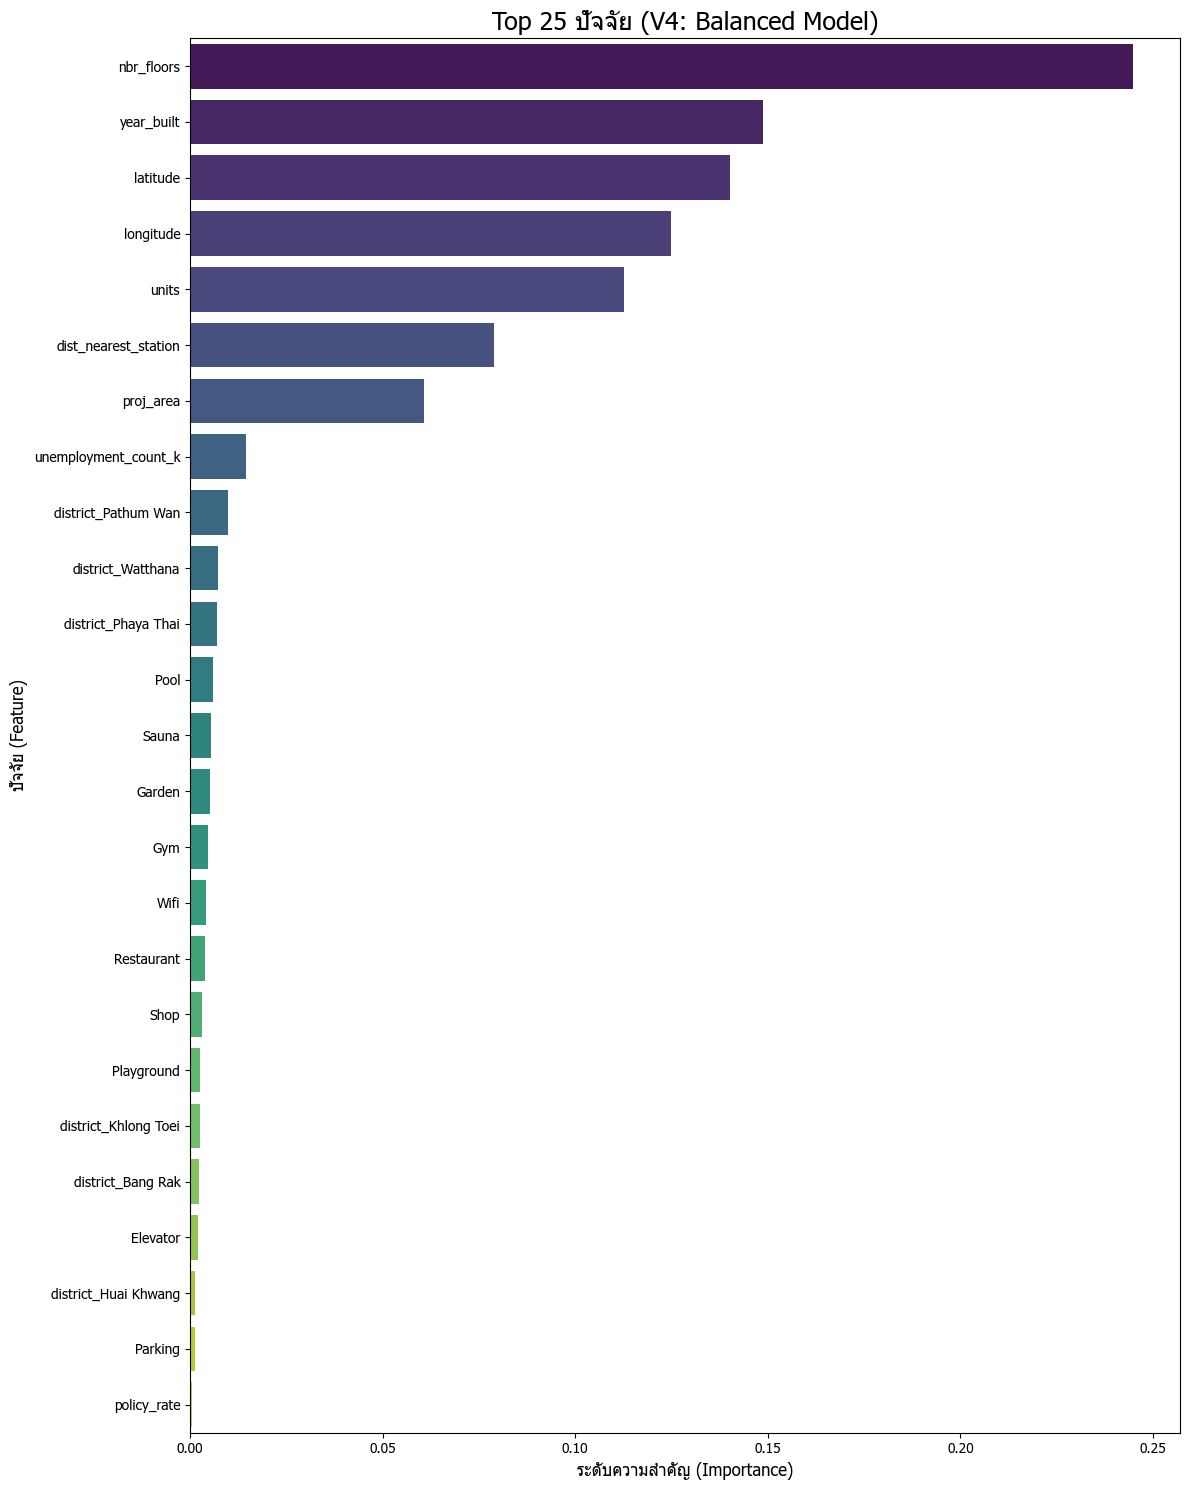

In [24]:
plt.figure(figsize=(12, 15))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance_df_v4.head(25),
    palette='viridis'
)
plt.title('Top 25 ปัจจัย (V4: Balanced Model)', fontsize=18)
plt.xlabel('ระดับความสำคัญ (Importance)', fontsize=12)
plt.ylabel('ปัจจัย (Feature)', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importances_full_model_v4.png')
plt.show()

### สรุปผลการวิเคราะห์ปัจจัย (Final Summary V4)
โมเดล V4 นี้มีความแม่นยำสูง (R2 = 84.16%) และมีค่า Error เฉลี่ยต่ำ (MAE = 8,584.48 บาท)
จากการวิเคราะห์โมเดลนี้ เราสรุปอิทธิพลของปัจจัยต่างๆ ได้ดังนี้:

In [25]:
top_5_features_v4 = feature_importance_df_v4.head(5)

print("5 ปัจจัยที่มีอิทธิพลสูงสุด")
for index, (i, row) in enumerate(top_5_features_v4.iterrows()):
    feature_name = row['feature']
    importance_pct = row['importance']
    print(f"  อันดับ {index + 1}: '{feature_name}' (ความสำคัญ: {importance_pct:.2%})")

print("\n การวิเคราะห์เชิงลึก (Deep Dive) V4")

5 ปัจจัยที่มีอิทธิพลสูงสุด
  อันดับ 1: 'nbr_floors' (ความสำคัญ: 24.48%)
  อันดับ 2: 'year_built' (ความสำคัญ: 14.89%)
  อันดับ 3: 'latitude' (ความสำคัญ: 14.02%)
  อันดับ 4: 'longitude' (ความสำคัญ: 12.48%)
  อันดับ 5: 'units' (ความสำคัญ: 11.26%)

 การวิเคราะห์เชิงลึก (Deep Dive) V4


In [26]:
try:
    geo_factor = 'dist_nearest_station'
    geo_rank = feature_importance_df_v4[feature_importance_df_v4['feature'] == geo_factor].index[0] + 1
    print(f"\n ปัจจัยภูมิศาสตร์:")
    print(f"  - 'dist_nearest_station' (ระยะทางไปรถไฟฟ้า) มีอิทธิพลสูงมาก (อันดับ {geo_rank})")
    print(f"  - 'latitude' และ 'longitude' (พิกัด) ก็มีความสำคัญสูง")
    print("  - การตีความ: 'ทำเล' คือหัวใจสำคัญของราคาอย่างแท้จริง")
except Exception as e:
    print(f"\n ปัจจัยภูมิศาสตร์: ไม่พบ 'dist_nearest_station'")


 ปัจจัยภูมิศาสตร์:
  - 'dist_nearest_station' (ระยะทางไปรถไฟฟ้า) มีอิทธิพลสูงมาก (อันดับ 19)
  - 'latitude' และ 'longitude' (พิกัด) ก็มีความสำคัญสูง
  - การตีความ: 'ทำเล' คือหัวใจสำคัญของราคาอย่างแท้จริง


In [27]:
facility_factors = ['Pool', 'Gym', 'Sauna', 'Wifi', 'Security', 'Parking']
facilities_importance = feature_importance_df_v4[feature_importance_df_v4['feature'].isin(facility_factors)].sort_values(by='importance', ascending=False)

if not facilities_importance.empty:
    top_facility_name = facilities_importance.iloc[0]['feature']
    top_facility_rank = facilities_importance.index[0] + 1
    
    print(f"\n ปัจจัยสิ่งอำนวยความสะดวก (Facilities):")
    print(f"  - ปัจจัยกลุ่มนี้แสดงอิทธิพลชัดเจนใน Top 20")
    print(f"  - ปัจจัยที่โดดเด่นที่สุดในกลุ่มนี้คือ '{top_facility_name}' (อันดับ {top_facility_rank} ในโมเดลรวม)")
    print("  - การตีความ: 'Pool', 'Gym', 'Sauna' ล้วนมีผลต่อราคาจริง")
else:
    print(f"\n ปัจจัยสิ่งอำนวยความสะดวก: ไม่พบใน Top list")


 ปัจจัยสิ่งอำนวยความสะดวก (Facilities):
  - ปัจจัยกลุ่มนี้แสดงอิทธิพลชัดเจนใน Top 20
  - ปัจจัยที่โดดเด่นที่สุดในกลุ่มนี้คือ 'Pool' (อันดับ 11 ในโมเดลรวม)
  - การตีความ: 'Pool', 'Gym', 'Sauna' ล้วนมีผลต่อราคาจริง


In [28]:
economic_factors = ['policy_rate', 'unemployment_count_k']
eco_importance_df = feature_importance_df_v4[feature_importance_df_v4['feature'].isin(economic_factors)].sort_values(by='importance', ascending=False)

print(f"\n ปัจจัยเศรษฐกิจ (ดอกเบี้ย/ว่างงาน):")
if not eco_importance_df.empty:
    top_eco_factor = eco_importance_df.iloc[0]['feature']
    top_eco_rank = eco_importance_df.index[0] + 1
    
    print(f"  - ปัจจัยเศรษฐกิจกลับมามีความสำคัญแล้ว เพราะโมเดลเห็นข้อมูลตลอดปี")
    print(f"  - '{top_eco_factor}' (จำนวนผู้ว่างงาน) มีอิทธิพลชัดเจน (อันดับ {top_eco_rank})")
    print("  - 'policy_rate' (ดอกเบี้ย) ก็กลับมามีอิทธิพล (แม้จะน้อยกว่า)")
    print("  - การตีความ: ภาวะเศรษฐกิจ (การจ้างงาน, ดอกเบี้ย) ส่งผลต่อกำลังซื้อและราคาอสังหาฯ จริง")
else:
    print(f"\n ปัจจัยเศรษฐกิจ: ไม่พบใน Top list")


 ปัจจัยเศรษฐกิจ (ดอกเบี้ย/ว่างงาน):
  - ปัจจัยเศรษฐกิจกลับมามีความสำคัญแล้ว เพราะโมเดลเห็นข้อมูลตลอดปี
  - 'unemployment_count_k' (จำนวนผู้ว่างงาน) มีอิทธิพลชัดเจน (อันดับ 21)
  - 'policy_rate' (ดอกเบี้ย) ก็กลับมามีอิทธิพล (แม้จะน้อยกว่า)
  - การตีความ: ภาวะเศรษฐกิจ (การจ้างงาน, ดอกเบี้ย) ส่งผลต่อกำลังซื้อและราคาอสังหาฯ จริง


In [29]:
import joblib

# 'model_rf' คือ Pipeline ของ V4 ที่เราฝึกเสร็จแล้ว
# (เราจะใช้ model_rf เพราะมันอธิบาย Feature Importance ได้)
model_to_save = model_rf 

# สั่งบันทึกโมเดลทั้งท่อ (Pre-processor + Model) ลงเป็นไฟล์
joblib.dump(model_to_save, 'real_estate_model_v4.joblib')

print("✅ บันทึกโมเดลสำเร็จ! ตอนนี้คุณมีไฟล์ 'real_estate_model_v4.joblib' แล้ว")

✅ บันทึกโมเดลสำเร็จ! ตอนนี้คุณมีไฟล์ 'real_estate_model_v4.joblib' แล้ว
